# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run sim_grid_func.py
%run functions.py


import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Neuron import Simulated_grid_cell, Simulated_conjunctive_grid_cell, Simulated_HD_Cell
from spikeA.Animal_pose import Animal_pose
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from spikeA.Neuron import Neuron
import datetime
from scipy import stats
from scipy import ndimage

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
GLOBALFONTSIZE = 11

# Data

In [4]:
onlyOF = myProject.dataPath + "/results/jp451_lstm_firstRF.npy"
lastOF = myProject.dataPath + "/results/jp451_lstm_lastRF.npy"

seed_value = 42
np.random.seed(seed_value)

In [5]:
def generate_offsets_gaussian(n_cells, period, dispersion=1.0):
    """
    Generate offset points with controlled dispersion using Gaussian distribution,
    with a randomly selected cluster center within the grid.

    Parameters:
    - n_cells (int): Number of cells.
    - period (array-like): Period array, where period[0] is used for scaling.
    - dispersion (float): Value between 0 (fully clustered) and 1 (fully dispersed).

    Returns:
    - offsets (ndarray): Array of shape (n_cells, 2) with offset points.
    """
    # Ensure dispersion is within [0, 1]
    dispersion = np.clip(dispersion, 0.0, 1.0)

    if dispersion == 0.0:
        # All points are at a random center
        center = np.random.rand(2) * period[0]
        return np.tile(center, (n_cells, 1))
    elif dispersion == 1.0:
        # Original uniform distribution
        return np.random.rand(n_cells, 2) * period[0]
    else:
        # Randomly select a cluster center within the grid
        center = np.random.rand(2) * period[0]
        
        # Define standard deviation based on dispersion
        max_std = period[0] / 5  # Adjust as needed for maximum spread
        std_dev = dispersion * max_std

        # Generate Gaussian-distributed points around the random center
        gaussian = np.random.randn(n_cells, 2) * std_dev + center

        # Clip points to stay within [0, period[0})
        gaussian_clipped = np.clip(gaussian, 0, period[0] - 1e-6)

        return gaussian_clipped



def generateTrainingFileFromSeed(seed,dispersion_level=1,spacing=35):
    np.random.seed(seed)

    grid_param = {}
    grid_param["n_cells"] = 8
    grid_param["orientation"] = np.array([0, np.pi / 3, np.pi / 3 * 2])
    grid_spacing = spacing
    grid_param["period"] = np.array(
        [
            grid_spacing * np.cos(np.pi / 6),
            grid_spacing * np.cos(np.pi / 6),
            grid_spacing * np.cos(np.pi / 6),
        ]
    )
    
    
    grid_param["offset"] = generate_offsets_gaussian(
    n_cells=grid_param["n_cells"],
    period=grid_param["period"],
    dispersion=dispersion_level
)
    peak_rates = np.random.normal(loc=25.0, scale=5.0, size=grid_param["n_cells"])
    peak_rates[peak_rates < 5] = 5
    grid_param["peak_rate"] = peak_rates

    return grid_param

In [6]:
generateTrainingFileFromSeed(12)

{'n_cells': 8,
 'orientation': array([0.        , 1.04719755, 2.0943951 ]),
 'period': array([30.31088913, 30.31088913, 30.31088913]),
 'offset': array([[ 4.67281282, 22.4315643 ],
        [ 7.98131223, 16.17811558],
        [ 0.44178007, 27.8480387 ],
        [27.30146808,  1.01303319],
        [29.00598524,  4.15893653],
        [ 8.60308974, 18.37092021],
        [28.62030341, 25.84717245],
        [ 0.06847938, 15.79882432]]),
 'peak_rate': array([20.96509061, 39.35909697, 22.0108854 , 27.36228497, 30.47978059,
        18.92415599, 31.71178186, 24.38925106])}

In [7]:
def plotMap(
    ax,
    myMap,
    title="",
    titleY=0.95,
    titleFontSize=GLOBALFONTSIZE-2,
    transpose=True,
    cmap="jet",
    vmin=0,
    alpha=1,
):
    """
    Plot one 2D map
    """
    if transpose:
        ax.imshow(
            myMap.T,
            origin="lower",
            cmap=cmap,
            interpolation=None,
            vmin=vmin,
            alpha=alpha,
        )
    else:
        ax.imshow(
            myMap, origin="lower", cmap=cmap, interpolation=None, vmin=vmin, alpha=alpha
        )
    ax.set_title(title, y=titleY, fontsize=titleFontSize)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

In [8]:
grid_param = generateTrainingFileFromSeed(1)

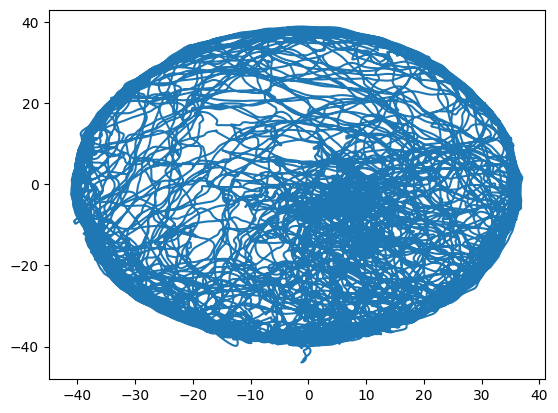

In [9]:
ap = Animal_pose()
ap.load_pose_from_file(file_name=onlyOF)

inter = ap.intervals.inter
ap.set_intervals(inter)


plt.plot(ap.pose[:, 1], ap.pose[:, 2])
plt.show()

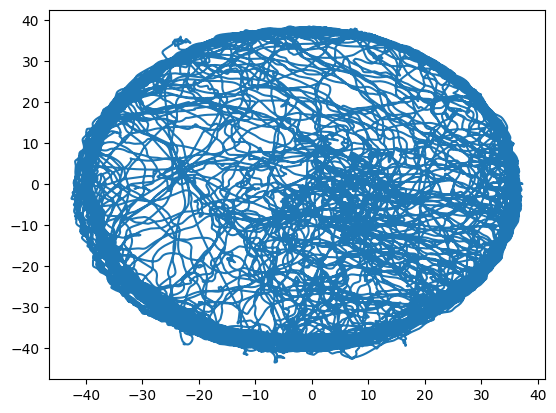

In [10]:
lap = Animal_pose()
lap.load_pose_from_file(file_name=lastOF)

plt.plot(lap.pose[:, 1], lap.pose[:, 2])
plt.show()

In [11]:
grid_param = generateTrainingFileFromSeed(1)

simulated_grid_cell_list = [
    Simulated_grid_cell(
        name=f"{i}",
        offset=grid_param["offset"][i, :],
        orientation=grid_param["orientation"],
        period=grid_param["period"],
        peak_rate=grid_param["peak_rate"][i],
        ap=ap,
    )
    for i in tqdm(range(grid_param["n_cells"]))
]

100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


# Plot these neurons

In [12]:
# We would like to plot the toroidal space map underneath the grid cell map
def plot_toroidal_space_from_neuron(ax,n,pose,grid_param):
    # Transform the pose into grid space
    gridSpacePose = poseToGridSpace(pose[:,1:3], grid_param["period"], grid_param["orientation"])
    v0 = np.arctan2(gridSpacePose[:,1],gridSpacePose[:,0])
    v1 = np.arctan2(gridSpacePose[:,3],gridSpacePose[:,2])
    v2 = np.arctan2(gridSpacePose[:,5],gridSpacePose[:,4])
    
    # Get the ifr
    
    n.spike_train.instantaneous_firing_rate(bin_size_sec = 0.02,sigma=2,shift_start_time =0.01,
                                                outside_interval_solution="remove")
    poseLong = ap.pose[:,1:3]
    keepIndices = ~np.any(np.isnan(poseLong),1)

    ifrs = n.spike_train.ifr[0][keepIndices]
    
    # Plot the map
    myMap,edges_x,edges_y,_ = stats.binned_statistic_2d(np.squeeze(v0),np.squeeze(v1),ifrs, statistic=np.nanmean,bins=20)
    myMap = ndimage.gaussian_filter(myMap,sigma=2,mode="wrap")
    ax.imshow(myMap.T,origin="lower",extent=[-np.pi,np.pi,-np.pi,np.pi],cmap='jet')
    ax.set_title("{:.2f} Hz".format(np.nanmax(myMap)),fontsize=GLOBALFONTSIZE-2)
    ax.set_xlabel("v0",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("v1",fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_yticks(ticks=[-np.pi, 0, np.pi])
    ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)

In [13]:
for n in simulated_grid_cell_list:
    n.spatial_properties.firing_rate_map_2d(cm_per_bin=3, smoothing_sigma_cm=5, smoothing=True)
    n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10,smoothing=True)  


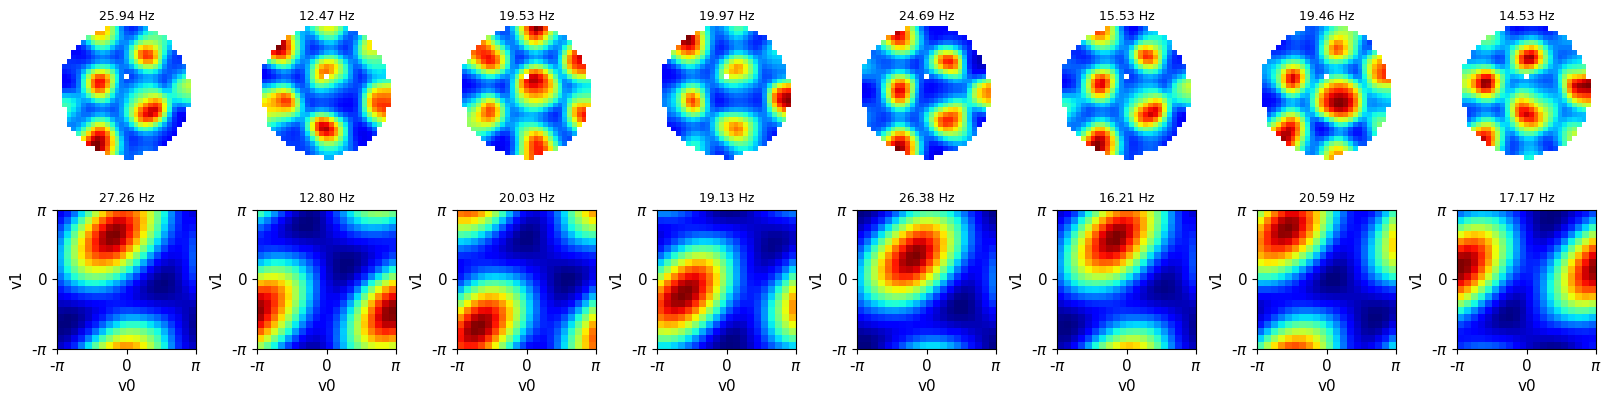

In [14]:
rowSize, colSize = 2, 2
ncols = 8

nrows = 2
fig = plt.figure(
    figsize=(ncols * colSize, nrows * rowSize), constrained_layout=True
)  # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)

maxHolder = []
for i, n in enumerate(simulated_grid_cell_list):
    #x = int(i / ncols)
    x = 0
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )
    maxHolder.append(np.nanmax(n.spatial_properties.firing_rate_map))
    
for i, n in enumerate(simulated_grid_cell_list):
    
    x = 1
    y = i % ncols
    ax = fig.add_subplot(mainSpec[x, y])
    
    plot_toroidal_space_from_neuron(ax,n,ap.pose,grid_param)

# Spacing vs grid disperseness

In [15]:
def calculate_MVL_based_on_df(inputDf):
    mvtDir = np.arctan2(inputDf.y.values,inputDf.x.values)
    predMvtDir = np.arctan2(inputDf.py.values,inputDf.px.values)
    mvtDirError = np.arctan2(np.cos(mvtDir)*np.sin(predMvtDir)-np.sin(mvtDir)*np.cos(predMvtDir),np.cos(mvtDir)*np.cos(predMvtDir)+np.sin(mvtDir)*np.sin(predMvtDir))

    mvtDirError = mvtDirError[~np.isnan(mvtDirError)]

    return np.round(vl_mvt_direction_error(mvtDirError),3)


In [16]:
dispersionList = [0.2,0.4,0.6,0.8,1] 
gridSpacingList = [25,30,35,40,45]


dfHolder = []

for ds in dispersionList[:]:
    for gs in gridSpacingList[:]:
        fn = myProject.dataPath + '/results/grid_spacing_and_dispersion'
        savePth = os.path.join(fn,f'ds{ds}_gs{gs}_8_grid_cell.csv')

        
        results = pd.read_csv(savePth)
        mvl = calculate_MVL_based_on_df(results[results.speed>10])
        
        resultDf = pd.DataFrame({
            "ds": [ds],
            "gs": [gs],
            "mvl": [mvl],
        })
        
        dfHolder.append(resultDf)
        

In [17]:
resultDfAll = pd.concat(dfHolder)

In [18]:
resultDfAll

,ds,gs,mvl
0,0.2,25,0.322
0,0.2,30,0.281
0,0.2,35,0.278
0,0.2,40,0.265
0,0.2,45,0.258
0,0.4,25,0.457
0,0.4,30,0.434
0,0.4,35,0.420
0,0.4,40,0.367
0,0.4,45,0.358


In [19]:
GLOBALFONTSIZE

11

In [20]:
def plot_model_mvl_with_different_gs_ds(ax,inputDf,x_var='',xlabel=''):
    
    pal = ['#00A7FF','#000EDD','#FFCF21','#FF9409','#FF5C00']
    
    mvl_stripplot_kwargs = dict(
    {"linewidth": 1, "size": 6, "alpha": 0.8},
    )
    
    od = inputDf[x_var].unique()
    
    sns.boxplot(data=inputDf,x=x_var,y='mvl',ax=ax,order=od,palette=pal,showfliers=False,**boxplot_kwargs)
    
    sns.stripplot(
        data=inputDf,x=x_var,y='mvl',order=od,ax=ax,palette=pal,
        edgecolor="black",
        #dodge=True,
        **mvl_stripplot_kwargs,
    )
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    ax.set_xlabel(xlabel,fontsize=GLOBALFONTSIZE)
    ax.set_ylabel('Direct. precision',fontsize=GLOBALFONTSIZE)

/tmp/ipykernel_322662/1836638152.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


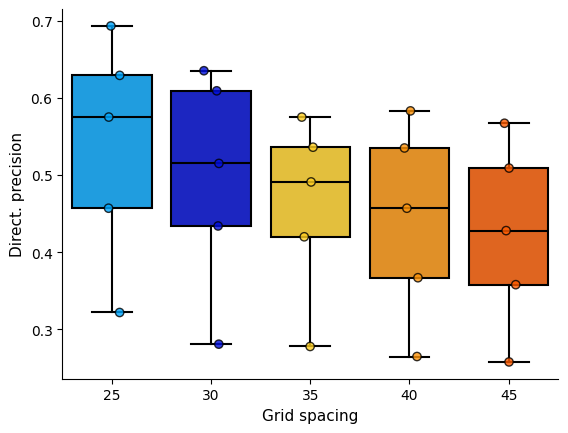

In [21]:
fig, ax = plt.subplots()
plot_model_mvl_with_different_gs_ds(ax,resultDfAll,x_var='gs',xlabel='Grid spacing')

<Axes: xlabel='gs', ylabel='mvl'>

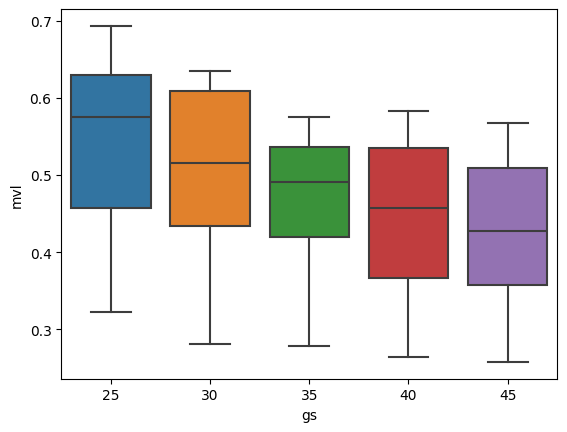

In [22]:
sns.boxplot(data=resultDfAll,x='gs',y='mvl')

<Axes: xlabel='ds', ylabel='mvl'>

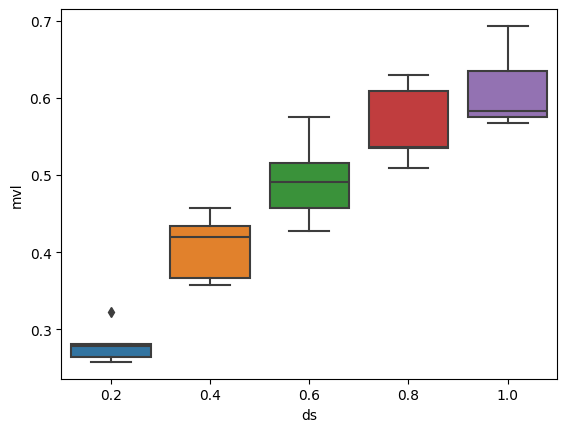

In [23]:
sns.boxplot(data=resultDfAll,x='ds',y='mvl')

<Axes: xlabel='gs', ylabel='ds'>

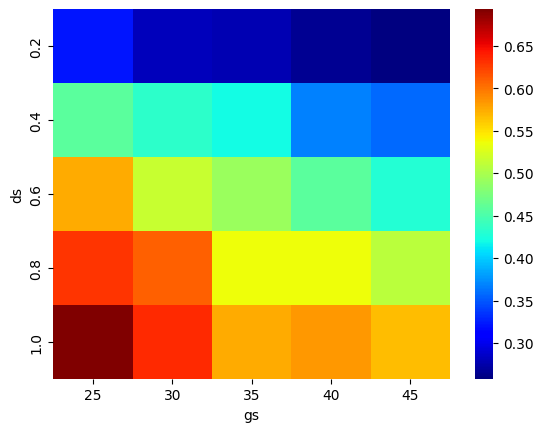

In [24]:
sns.heatmap(resultDfAll.pivot_table(index='ds',columns='gs',values='mvl'),cmap='jet')

In [25]:
resultDfAll

,ds,gs,mvl
0,0.2,25,0.322
0,0.2,30,0.281
0,0.2,35,0.278
0,0.2,40,0.265
0,0.2,45,0.258
0,0.4,25,0.457
0,0.4,30,0.434
0,0.4,35,0.420
0,0.4,40,0.367
0,0.4,45,0.358


# Make final figure

In [26]:
seed = 42

In [27]:
grid_param_20_35 = generateTrainingFileFromSeed(seed,dispersion_level=0.2,spacing=35)

simulated_grid_cell_list_20_35 = [
    Simulated_grid_cell(
        name=f"{i}",
        offset=grid_param_20_35["offset"][i, :],
        orientation=grid_param_20_35["orientation"],
        period=grid_param_20_35["period"],
        peak_rate=grid_param_20_35["peak_rate"][i],
        ap=ap,
    )
    for i in tqdm(range(grid_param_20_35["n_cells"]))
]

100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


In [28]:
grid_param_100_35 = generateTrainingFileFromSeed(seed,dispersion_level=1,spacing=35)

simulated_grid_cell_list_100_35 = [
    Simulated_grid_cell(
        name=f"{i}",
        offset=grid_param_100_35["offset"][i, :],
        orientation=grid_param_100_35["orientation"],
        period=grid_param_100_35["period"],
        peak_rate=grid_param_100_35["peak_rate"][i],
        ap=ap,
    )
    for i in tqdm(range(grid_param_100_35["n_cells"]))
]

100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


In [29]:
grid_param_100_25 = generateTrainingFileFromSeed(seed,dispersion_level=1,spacing=25)

simulated_grid_cell_list_100_25 = [
    Simulated_grid_cell(
        name=f"{i}",
        offset=grid_param_100_25["offset"][i, :],
        orientation=grid_param_100_25["orientation"],
        period=grid_param_100_25["period"],
        peak_rate=grid_param_100_25["peak_rate"][i],
        ap=ap,
    )
    for i in tqdm(range(grid_param_100_25["n_cells"]))
]

100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


In [30]:
grid_param_100_45 = generateTrainingFileFromSeed(seed,dispersion_level=1,spacing=45)

simulated_grid_cell_list_100_45 = [
    Simulated_grid_cell(
        name=f"{i}",
        offset=grid_param_100_45["offset"][i, :],
        orientation=grid_param_100_45["orientation"],
        period=grid_param_100_45["period"],
        peak_rate=grid_param_100_45["peak_rate"][i],
        ap=ap,
    )
    for i in tqdm(range(grid_param_100_45["n_cells"]))
]

100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


In [31]:
sim_list = [simulated_grid_cell_list_20_35,simulated_grid_cell_list_100_35,simulated_grid_cell_list_100_25,simulated_grid_cell_list_100_45]
for sl in sim_list:
    for n in sl:
        n.spatial_properties.firing_rate_map_2d(cm_per_bin=3, smoothing_sigma_cm=5, smoothing=True)
        n.spatial_properties.firing_rate_head_direction_histogram(deg_per_bin=10, smoothing_sigma_deg=10,smoothing=True)  

# Final figure

/tmp/ipykernel_322662/1836638152.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/tmp/ipykernel_322662/1836638152.py:13: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


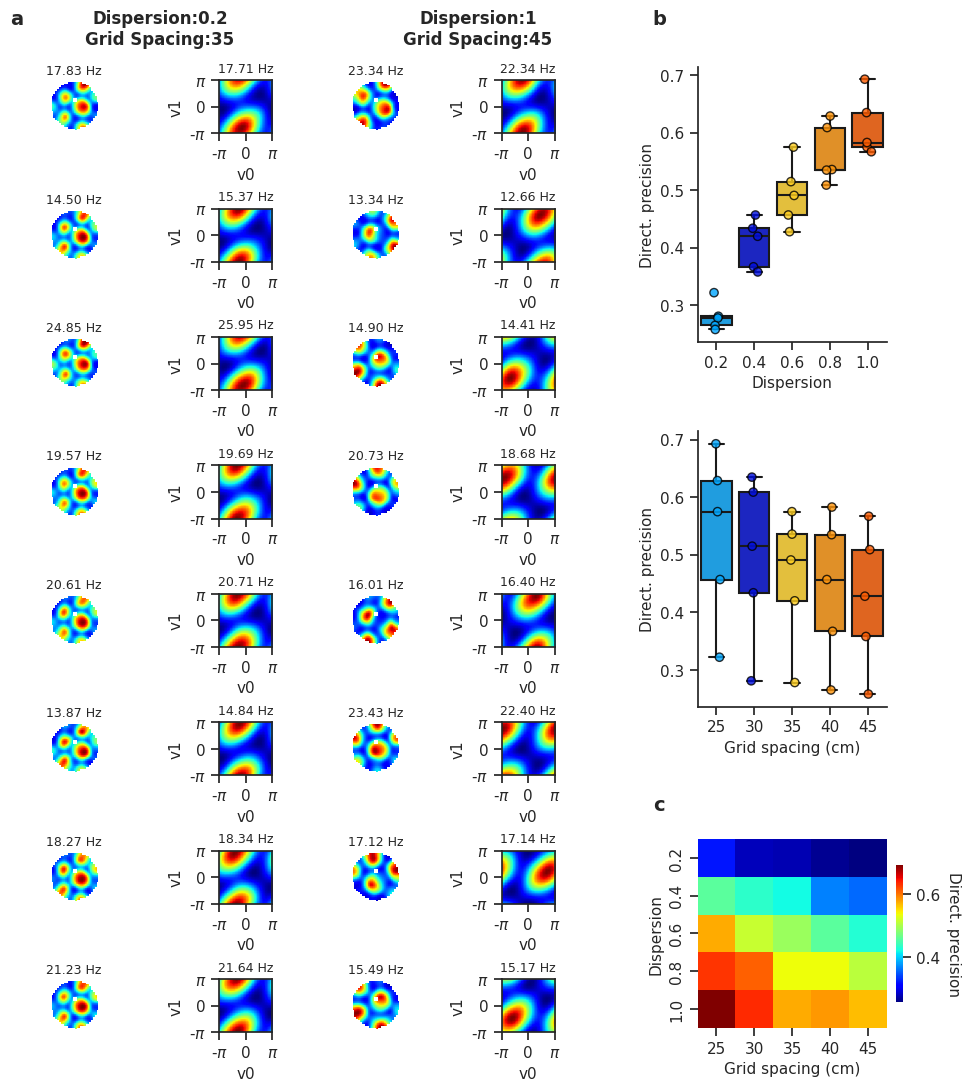

In [32]:
from matplotlib.gridspec import GridSpecFromSubplotSpec

rowSize,colSize= 1.8,1.6
ncols=6
nrows=6
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = fig.add_gridspec(ncols=ncols, nrows=nrows,hspace=0,wspace=0,width_ratios=[1,1,1,1,1,1.1],height_ratios=[1,1,1,1,1,1])
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

import random

random.seed(0)


# NOTE Dispersion 0.2, Spacing 35
gs_d20 = GridSpecFromSubplotSpec(9,3,subplot_spec=gs[:,:2],height_ratios=[0.02]+[1]*8,width_ratios=[1,1,0.05],hspace=0,wspace=0)

ax0 = fig.add_subplot(gs_d20[0,:2])
ax0.set_title('Dispersion:0.2\nGrid Spacing:35',fontsize=GLOBALFONTSIZE+1,fontweight='bold')
ax0.axis('off')

for i, n in enumerate(simulated_grid_cell_list_20_35[:]):
    x = 1+i
    y = 0
    ax = fig.add_subplot(gs_d20[x, y])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )
    
for i, n in enumerate(simulated_grid_cell_list_20_35[:]):
    
    x = 1+i
    y = 1
    ax = fig.add_subplot(gs_d20[x, y])
    plot_toroidal_space_from_neuron(ax,n,ap.pose,grid_param_20_35)


# NOTE Dispersion 1, Spacing 45
gs_d100_45 = GridSpecFromSubplotSpec(9,3,subplot_spec=gs[:,2:4],height_ratios=[0.02]+[1]*8,width_ratios=[1,1,0.05])

ax0 = fig.add_subplot(gs_d100_45[0,:])
ax0.set_title('Dispersion:1\nGrid Spacing:45',fontsize=GLOBALFONTSIZE+1,fontweight='bold')
ax0.axis('off')

for i, n in enumerate(simulated_grid_cell_list_100_45[:]):
    x = 1+i
    y = 0
    ax = fig.add_subplot(gs_d100_45[x, y])
    plotMap(
        ax,
        n.spatial_properties.firing_rate_map,
        title="{0:.2f} Hz".format(np.nanmax(n.spatial_properties.firing_rate_map)),
    )
    
for i, n in enumerate(simulated_grid_cell_list_100_45[:]):
    x = 1+i
    y = 1
    ax = fig.add_subplot(gs_d100_45[x, y])
    plot_toroidal_space_from_neuron(ax,n,ap.pose,grid_param_100_45)
    
    
    
# NOTE Plot the stats for these different types
stats_gs = GridSpecFromSubplotSpec(4,1,subplot_spec=gs[:,4:],height_ratios=[0.15,1,1,1],hspace=0.15)

ax0 = fig.add_subplot(stats_gs[1,0])
plot_model_mvl_with_different_gs_ds(ax0,resultDfAll,x_var='ds',xlabel='Dispersion')

ax0 = fig.add_subplot(stats_gs[2,0])
plot_model_mvl_with_different_gs_ds(ax0,resultDfAll,x_var='gs',xlabel='Grid spacing (cm)')


ax0 = fig.add_subplot(stats_gs[3,0])
b = sns.heatmap(resultDfAll.pivot_table(index='ds',columns='gs',values='mvl'),cmap='jet',ax=ax0, cbar_kws={'shrink': 0.5})
ax0.set_aspect('equal')
ax0.set_ylabel('Dispersion',fontsize=GLOBALFONTSIZE)
ax0.set_xlabel('Grid spacing (cm)',fontsize=GLOBALFONTSIZE)

# Customize the color bar
colorbar = b.collections[0].colorbar
colorbar.set_label('Direct. precision', rotation=270, labelpad=15, fontsize=GLOBALFONTSIZE)  # Set sideways title




gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0.68,1,'b',fw='900')
add_text(ax0,0.68,0.26,'c',fw='900')

ax0.axis('off')
###

plt.savefig('../../Output/Sup_Figure2.pdf', bbox_inches='tight', dpi=300)